<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [7]:
import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
import pandas_datareader.data as dtr
import requests_cache
import datetime
from tqdm.notebook import tqdm
from concurrent import futures
expire_after = datetime.timedelta(days = 7)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

tickers = ["LNTA.ME","MGNT.ME","PIKK.ME",
           "MTSS.ME","MGTS.ME","RTKM.ME",
           "ROSN.ME","GAZP.ME","NVTK.ME","LKOH.ME","TATN.ME","SNGS.ME","SIBN.ME",
           "PLZL.ME","NLMK.ME","CHMF.ME","POLY.ME","RUAL.ME","ALRS.ME",
           "SBER.ME","VTBR.ME","MOEX.ME","CBOM.ME","YNDX.ME","CBOM.ME","ROSB.ME",
           "HYDR.ME","RSTI.ME","FEES.ME"
          ]

df = pd.DataFrame()

for ticker in tickers:
    try:
        df_ = dtr.DataReader(ticker, data_source="yahoo" , session=session, retry_count=1)
        df_.insert(0, "ticker", ticker)
    except:
        print(f"ticker '{ticker}' failed")
        pass
    df = df.append(df_)

GAZP = df[df.ticker == "GAZP.ME"]
GAZP.head()

,ticker,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,
2015-12-18,GAZP.ME,137.389999,132.250000,137.289993,132.250000,38544860.0,132.250000
2015-12-21,GAZP.ME,133.940002,131.000000,132.000000,131.500000,28393100.0,131.500000
2015-12-22,GAZP.ME,133.539993,131.809998,132.000000,133.199997,20022420.0,133.199997
2015-12-23,GAZP.ME,135.300003,133.350006,133.550003,135.300003,26760910.0,135.300003
2015-12-24,GAZP.ME,138.080002,134.449997,135.850006,136.000000,36828650.0,136.000000


In [9]:
class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10
    
    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        
    def next(self):
        
        if not self.position:
            
            # On upwards trend, if price closes above
            # "entry" MA, go long
            
            # self.sma1 and self.sma2 are of class Indicator
            # thus the last value is used for comparison
            # this is unlike usual nd.arrays
            if self.sma1 > self.sma2:
                if crossover(self.data.Close, self.sma_enter):
                    self.buy()
                    
            # On downwards trend, if price closes below
            # "entry" MA, go short
            
            else:
                if crossover(self.sma_enter, self.data.Close):
                    self.sell()
        
        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position
        
        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):
                
                self.position.close()
       
backtest = Backtest(GAZP, Sma4Cross, commission=.002)

In [10]:
stats, heatmap = backtest.optimize(
    n1=range(10, 50, 3),
    n2=range(20, 100, 3),
    n_enter=range(10, 50, 3),
    n_exit=range(10, 50, 3),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=None,
    random_state=0,
    method="grid",
    return_heatmap=True,   
)
stats['Return (Ann.) [%]']

/home/sergey/anaconda3/lib/python3.7/site-packages/backtesting/backtesting.py:1468: UserWarning: Searching for best of 7188 configurations.
  output = _optimize_grid()


CPU times: user 593 ms, sys: 53.1 ms, total: 646 ms
Wall time: 1min 9s


8.135738398587943

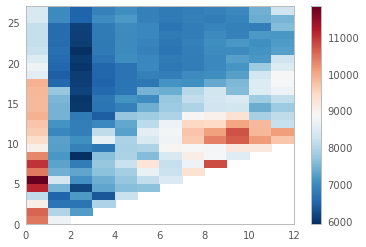

In [43]:
hm=heatmap.groupby(["n1","n2"]).agg("mean").unstack("n1")

plt.pcolor(hm, cmap="RdBu_r")
plt.colorbar();

In [3]:
params = []
for n1 in range(10, 50, 3):
    for n2 in range(20, 100, 3):
        for n_enter in range(10, 50, 3):
            for n_exit in range(10, 50, 3):
                if n_exit < n_enter < n1 < n2:
                    params.append({"n1":n1,"n2":n2,"n_exit":n_exit,"n_enter":n_enter})

In [88]:
%%time
for param in params:
    backtest.run(**param)

CPU times: user 7min 20s, sys: 260 ms, total: 7min 21s
Wall time: 7min 20s


In [40]:
from datetime import datetime
start = datetime.now()

def backtest_wrapper(x):
    return backtest.run(**x)

with futures.ProcessPoolExecutor() as executor:
    ## can't use lambda cause it's not serializable
    stats = executor.map(backtest_wrapper, params) 
    
print(datetime.now() - start)
# 0:01:17.346338

0:01:15.606029


In [6]:
%%time
stats = backtest.optimize(
    n1=range(10, 50, 3),
    n2=range(20, 100, 3),
    n_enter=range(10, 50, 3),
    n_exit=range(10, 50, 3),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Equity Final [$]',
    max_tries=30,
    random_state=42,
    method="skopt"
)
stats['Return (Ann.) [%]']

CPU times: user 1.15 s, sys: 57.7 ms, total: 1.21 s
Wall time: 1.21 s


1.7165487220489606